# Building with LangGraph: State Management and Graph Structures

LangGraph is a powerful framework for building complex AI agent systems using directed graphs. This section covers the foundational concepts of state management and basic graph structures.

## Key Concepts
- State: Persistent data that flows through the graph
- Nodes: Processing units that transform state
- Edges: Connections defining how data flows between nodes

In [ ]:
# Let's make sure our requirements are installed, even though I expect you already set up in part 1
!pip install -r ../requirements.txt

# State Flow in LangGraph

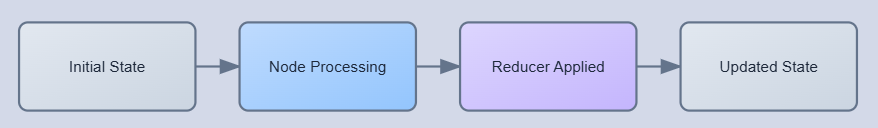

## Understanding Reducers

Reducers are functions that determine how state updates happen:
1. Default behavior: Replace existing value
2. Custom reducers (using Annotated):
   - List append (message_history)
   - Increment (counter)
   - Two input arguments: previous state, new value

Example flow:
Initial State -> Node Processing -> Reducer Applied -> Updated State

> ⚠️ **Note about Counters**: The counter only increments when explicitly updated in the state. This is intentional and demonstrates how reducers work with explicit state updates.

In [ ]:
# This is an example reducer for our counter, 
def increment(a:int,b:int)-> int:
    return a+1


In [119]:
# Practical Reducer Examples
from operator import add
# Example 1: Message History
messages = ["Hello"]
new_message = ["How are you?"]
# With add reducer:
result = add(messages, new_message)  # ["Hello", "How are you?"]
print(f"add({messages}, {new_message})")
print(result)
print("\n\n")
# Example 2: Counter
current = 5
new_value = 10
# With increment reducer:
result = increment(current, new_value)  # 6 (always current + 1)
print(f"increment({current}, {new_value})")
print(result)
# This is why our counter field uses Annotated[int, increment]:
# counter: Annotated[int, increment] = 0

add(['Hello'], ['How are you?'])
['Hello', 'How are you?']



increment(5, 10)
6


In [ ]:
from typing import List, Annotated, Optional
from pydantic import BaseModel, Field
from datetime import datetime


#Create a custom message model
class Message(BaseModel):
    """
    The Message model represents individual communications in our graph:
    - message: The content of the communication
    - timestamp: When the message was created (auto-generated)
    - source: Origin of the message (e.g., "user", "agent")

    This model will be used to track all interactions within our graph system.
    """
    message : str
    timestamp : datetime = Field(default_factory=datetime.now)
    source : str
    
#Define a simple state
#States get updated by reduce, by default parameters get replaced. If we provide a reduction function with Annotated type, this function will be called to update the state
class GraphState(BaseModel):
    """
    GraphState manages persistent data across graph execution:
    - message_history: List of all messages, using custom reducer for append operations
    - test_flag: Boolean flag for testing/debugging
    - counter: Numeric value that auto-increments using custom reducer, only increments if passed
    """
    # While this happens by default, we created a message history which will append to our list
    message_history: Annotated[List[Message], add] = Field(default_factory = list)
    test_flag: bool = False
    #Counter - this will increase by one at each update of the graph state - increment is our reducer function, which takes two arguments
    counter: Annotated[int, increment] = 0

# Nodes

Nodes act on the graph state by the function they are defined by

In [ ]:
#We define our first node function - user message

def user_input_node(state:GraphState):
    user_message = input(
        "Type your message:"
    )
    state.message_history = [Message(
        message = user_message,
        source = "User",
        counter = state.counter
    )]
    return state

# Building our first graph 

A graph needs:
- A START point
- A node
- An END point

In [ ]:
from langgraph.graph import START, END, StateGraph
# Create an initial StateGraph
graph_builder = StateGraph(GraphState)

graph_builder.add_node("single_node - user_input", user_input_node)

graph_builder.add_edge(START,"single_node - user_input")
graph_builder.add_edge("single_node - user_input", END)

# Compile the graph
app = graph_builder.compile()

In [ ]:
#Create a mermaid diagram of the graph - we need to import IPython.display to display it in Jupyter
mermaid_str = app.get_graph().draw_mermaid()

from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# Let's run our single node graph 
# It will ask for your prompt
# No followup action will happen
results = app.invoke(input = GraphState.model_construct())

for item in results.items():
    print(item)

# From Basic State to Agent Chains

Now that we understand how state flows through our graph and how reducers work, let's put this knowledge to use by building a conversational agent chain. We'll see how our GraphState evolves as it passes through multiple nodes, and how the message_history and counter fields get updated at each step.

Key transition concepts:
- State now flows through multiple nodes
- Each node can modify the message_history
- Counter tracks the flow through the chain

In [ ]:
#Let's load our model and key - we will use the test_agent client to make LLM calls.

#Ignore this code section

from pathlib import Path
from typing import Tuple
import os
from dotenv import load_dotenv

def load_llm_config() -> Tuple[str, str]:
    """
    Load LLM provider and API key from environment variables or .env file.
    Prioritizes environment variables over .env file settings.
    
    Returns:
        Tuple[str, str]: (provider, api_key)
    
    Raises:
        KeyError: If required configuration is missing from both sources
        ValueError: If provider or API key validation fails
    """
    # Load .env file if it exists (as fallback)
    env_path = Path('.env')
    if env_path.exists():
        load_dotenv()
    
    # Try environment variables first, then fall back to loaded .env values
    provider = os.getenv('LLM_PROVIDER')
    api_key = os.getenv('LLM_API_KEY')
    
    # Check if either value is missing
    missing_vars = []
    if not provider:
        missing_vars.append('LLM_PROVIDER')
    if not api_key:
        missing_vars.append('LLM_API_KEY')
    
    if missing_vars:
        raise KeyError(
            f"Missing required configuration: {', '.join(missing_vars)}. "
            "Please set environment variables or create .env file."
        )
    
    # Validate provider
    valid_providers = {"AI Studio", "Claude", "OpenAI", "DeepSeek"}
    if provider not in valid_providers:
        raise ValueError(
            f"Invalid provider '{provider}'. "
            f"Must be one of: {', '.join(valid_providers)}"
        )
    
    # Validate API key is not empty
    if not api_key.strip():
        raise ValueError("API key cannot be empty")
        
    return provider, api_key


# Nest asyncio is required as Pydantic uses an asyncrounous call - and jupyter is asyncrounous by default.
import nest_asyncio
nest_asyncio.apply()

from pydantic_ai.models.anthropic import AnthropicModel
from pydantic_ai.models.openai import OpenAIModel
from pydantic_ai.models.gemini import GeminiModel #This is recommended for testing only - for production use VertexAI
from pydantic_ai import Agent

success = False
while not success:
    provider, api_key = load_llm_config()

    match provider:
        case "AI Studio":
            model = GeminiModel(
                "gemini-2.0-flash-exp",
                api_key  = api_key
            )
        case "Claude":
            model = AnthropicModel(
                "claude-3-5-sonnet-latest",
                api_key  = api_key
            )
        case "OpenAI":
            model = OpenAIModel(
                "gpt-4o",
                api_key  = api_key
            )
        case "DeepSeek": 
            model = OpenAIModel(
                "DeepSeek-V3",
                base_url = "https://api.deepseek.com/v1",
                api_key  = api_key
            )
        #Define a test agent for testing.
    test_agent = Agent(model)
    try:
        # This is why we need the nest_asyncio
        response = test_agent.run_sync(
            user_prompt = "Test call")
        print(f"Response received successfully from {provider}!")

        print(response.data)
        success = True
    except:
        print("Invalid API key")


# Building Agent Chains

This section demonstrates how to create sequential processing chains where each node builds upon the previous node's output. We'll create a simple conversational flow:

1. User Input → 2. Agent Processing → 3. Output

## Design Principles
- Each node has a single responsibility
- State flows linearly through the chain
- Errors are handled at each step

In [ ]:
#Lets add an LLM model node to respond in our graph.
# We will simply call the agent with the last response as an input message
def agent_call_node(state:GraphState)-> GraphState:
    """
    Process user input using an LLM agent.
    
    Flow:
    1. Extract last message from state
    2. Send to LLM for processing
    3. Create new state with response
    
    Args:
        state (GraphState): Current graph state containing message history
        
    Returns:
        GraphState: Updated state with agent's response
    """
    last_message = state.message_history[-1].message
    response = test_agent.run_sync(
        user_prompt = last_message
    )
    return GraphState(
        message_history = [Message(
            message = response.data,
            source = "agent"
        )],
        test_flag = True
    )


### State Persistence
Important: Each node should handle state appropriately:
- Return complete state objects
- Preserve necessary history
- Update counters when needed

In [ ]:
# We are building out our chained
from langgraph.graph import START, END, StateGraph
# A single chained graph
graph_builder = StateGraph(GraphState)

graph_builder.add_node("user_input", user_input_node)
graph_builder.add_node("agent_node", agent_call_node)


graph_builder.add_edge(START,"user_input")
graph_builder.add_edge("user_input", "agent_node")
graph_builder.add_edge("agent_node", END)


# Compile the graph
app = graph_builder.compile()

#Creat
mermaid_str = app.get_graph().draw_mermaid()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# Let's test how the chained graph behaves

results = app.invoke(input = GraphState.model_construct())
print(results["message_history"])
for item in results["message_history"]:
    print(item)

print(results["counter"])

# Moving to Advanced Patterns

Our simple chain demonstrates basic flow, but real applications often need more complex patterns. Let's explore how to:
1. Route messages to specialized handlers
2. Process multiple aspects of a request in parallel
3. Combine multiple agent outputs into a coherent response

This section builds on our state management knowledge while introducing conditional flows and concurrent processing.


# Advanced Graph Patterns: Routing and Parallel Processing

This section covers two advanced patterns:
1. Conditional Routing: Directing flow based on message content
2. Parallel Processing: Running multiple agents concurrently

## When to Use
- Routing: When different types of requests need different handling
- Parallel: When multiple independent analyses can run simultaneously



### Routing Logic
The router uses a simple keyword-based approach:
- Checks for "question", "task", or "instruction" in lowercase message
- Returns corresponding route string
- Throws exception for unmatched cases

Consider extending this with:
- Fuzzy matching
- Default routes
- Multiple category handling

In [ ]:
# Now let's check - how we branch our graph - conditional routing
from pydantic_ai import Agent
# Redefine our agent nodes for the sake of the example
# We will have 3 catogories - question, task, instruction - which will be handed off to different agents

# Let's define our graph router

def graph_router(state:GraphState):
    """
    Routes messages based on content classification.
    
    Routing Logic:
    - Questions → Question handling node
    - Tasks → Task processing node
    - Instructions → Instruction handling node
    
    Raises:
        Exception: If message cannot be categorized
        
    Note: Consider adding fallback handling for edge cases
    """
    last_response = state.message_history[-1].message.lower()
    if "question" in last_response:
        return "question"
    elif "task" in last_response:
        return "task"
    elif "instruction" in last_response:
        return "instruction"
    else:
        raise Exception("incorrect or missing category")

# Let's define our nodes and LLM calls(we wrap it in 'agents')

categorization_agent = Agent(
    model,
    system_prompt = """
    Categorize the user request into one of the following categories : 
    1. Question,
    2. Task,
    3. Instruction
    """)

def user_input_node(state:GraphState):
    user_message = input(
        "Type your message:"
    )
    state.message_history = [Message(
        message = user_message,
        source = "User",
        counter = state.counter
    )]
    return state

def categorization_node(state:GraphState):
    response = categorization_agent.run_sync(state.message_history[-1].message)
    print(response)
    return {
        "message_history" : [Message(message=response.data, source= "agent")]
    }

question_agent = Agent(
    model,
    system_prompt = """
    Answer the user question
    """)

def question_node(state:GraphState):
    response = question_agent.run_sync(state.message_history[-2].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")],
        "counter" : state.counter
    }

task_agent = Agent(
    model,
    system_prompt = """
    Complete the task provided
    """)

def task_node(state:GraphState):
    response = task_agent.run_sync(state.message_history[-2].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")],
        "counter" : state.counter
    }

instruction_agent = Agent(
    model,
    system_prompt = """
    Follow the instruction provided
    """)

def instruction_node(state:GraphState):
    response = instruction_agent.run_sync(state.message_history[-2].message)
    return {
        "message_history" : [Message(message=response.data, source= "agent")],
        "counter" : state.counter
    }




Let's define our graph with the functions we created

In [ ]:
# Lets build our graph quickly

routing_graph_builder = StateGraph(GraphState)
#Lets define our nodes
routing_graph_builder.add_node("user input", user_input_node)
routing_graph_builder.add_node("categorization", categorization_node)
routing_graph_builder.add_node("question_node", question_node)
routing_graph_builder.add_node("task_node", task_node)
routing_graph_builder.add_node("instruction_node", instruction_node)

# Let's define our edges
routing_graph_builder.add_edge(START,"user input")
routing_graph_builder.add_edge("user input","categorization")

# I'm using string output for the routing keys - as this output is displayed in the mermaid diagram
routing_graph_builder.add_conditional_edges(
    "categorization",
    graph_router,
    {
        "question": "question_node", 
        "task":"task_node" , 
        "instruction": "instruction_node"}
    )

routing_graph_builder.add_edge("question_node",END)
routing_graph_builder.add_edge("task_node",END)
routing_graph_builder.add_edge("instruction_node",END)

# Let's draw our graph

# Compile the graph
router_app = routing_graph_builder.compile()

#Creat
mermaid_str = router_app.get_graph().draw_mermaid()

try:
    display(Image(router_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

# Run the graph

Note : The counter only increments if we pass a new value.

In [ ]:
# Let's run our model with streamed responses

events = router_app.stream(input = GraphState.model_construct(), stream_mode="updates")
for s in events:
  for node,event  in s.items():
    print("".ljust(30,"_"))
    print(str(node.upper()).ljust(30,"#"))
    print("".ljust(30,"_"))
    for key,value in event.items():
      if key == "message_history":
        print("Message History:")
        for message_object in value:
          print(f"Source : {message_object.source} at {message_object.timestamp}")
          print(message_object.message)
      else:
        print(f"{key} : {value}")


## Parallel Processing Architecture

Our system uses four specialized agents:
1. Master Architect: Orchestrates overall process
2. Cloud Architect: Technical implementation
3. Security Engineer: Security considerations
4. UX Designer: User experience aspects

Benefits:
- Concurrent execution saves time
- Specialized expertise for each aspect
- Comprehensive final summary

### System Prompts
The workshop uses focused system prompts for each agent:
- Master Architect: Orchestration and delegation
- Cloud Architect: Technical implementation
- Security Engineer: Security considerations
- UX Designer: User experience

Consider customizing these prompts for your specific use case.

In [ ]:
# Lets define our pydantic agents
#We create a separate http client for each model - so they don't block each other

master_architect = Agent(
    model,
    system_prompt = """
    You are a master architect,
    Your responsibility is to collect user question,
    generate an initial draft - delegate it to subject matter experts,
    then summarize the result and send it to the user.
    We have 3 user matter experts available, and each of them will work independently
    """
)


cloud_architect = Agent(
    model,
    system_prompt = """
    You are the cloud architect
    You will be receiving an overall idea draft - you will have to provide input as a certified cloud engineer,
    Your skills focus on building and delivering solutions by integrating cloud services or building custom solutions
    You work with a security_engineer and ux designer - and the master architect will take in all your inputs
    """)


security_engineer = Agent(
    model,
    system_prompt = """
    You are the security engineer,
    You will be receiving an overall idea draft - you will have to provide input as a certified security expert,
    Your skills focus on establishing best security principles, understanding the threat model, risks, vulnerabilities 
    and solutions.
    You work with a cloud_engineer and ux designer - and the master architect will take in all your inputs
    """)



ux_designer = Agent(
    model,
    system_prompt = """
    You are a user experience designer,
    You will be receiving an overall idea draft - you will have to provide input as a expert ux designer,
    Your skills will focus on ensuring great user experience, establishing research and accessibility principles,
    Through the user experience, you will have some role with branding as well - as you will lead us in understanding our users, besides 
    provding support in making technical decisions and general direction from a user experience perspective
    You work with a cloud_engineer and a security engineer - and the master architect will take in all your inputs
    """)

In [ ]:
# Now let's define the functions for our nodes.


def user_input_node(state:GraphState):
    user_message = input(
        "Make a request to the master architect:"
    )
    state.message_history = [Message(
        message = user_message,
        source = "User",
        counter = state.counter
    )]
    return state

async def ma_drafting_node(state:GraphState):
    print("Drafting Plan")
    try:
        response = await master_architect.run(state.message_history[-1].message)
    except Exception as e:
        logger.error(f"Agent error: {e}")
        return GraphState(
            message_history=[Message(
                message="Error processing request",
                source="error"
            )]
        )
    
    return {
        "message_history" : [Message(message=response.data, source= "agent-master-architect")],
        "counter" : state.counter
    }

async def ca_node(state:GraphState):
    print("CA Working...")
    try:
        response = await cloud_architect.run(state.message_history[-1].message)
    except Exception as e:
        logger.error(f"Agent error: {e}")
        return GraphState(
            message_history=[Message(
                message="Error processing request",
                source="error"
            )]
        )
    print("CA process done...")
    return {
        "message_history" : [Message(message=response.data, source= "agent-cloud-architect")],
        "counter" : state.counter
    }
async def se_node(state:GraphState):
    print("SE Working...")
    try:
        response = await security_engineer.run(state.message_history[-1].message)
    except Exception as e:
        logger.error(f"Agent error: {e}")
        return GraphState(
            message_history=[Message(
                message="Error processing request",
                source="error"
            )]
        )
    print("SE process done...")
    return {
        "message_history" : [Message(message=response.data, source= "agent-security-architect")],
        "counter" : state.counter
    }
async def ux_node(state:GraphState):
    print("UX Working...")
    try:
        response = await ux_designer.run(state.message_history[-1].message)
    except Exception as e:
        logger.error(f"Agent error: {e}")
        return GraphState(
            message_history=[Message(
                message="Error processing request",
                source="error"
            )]
        )
    print("UX process done...")
    return {
        "message_history" : [Message(message=response.data, source= "agent-ux-architect")],
        "counter" : state.counter
    }

async def ma_summary_node(state:GraphState):
    print("Summarizing...")
    message_summary = ""
    for message in state.message_history:
        message_summary += message.source + ":\n\n" + message.message
    try:
        response =await master_architect.run(
            "Now create a final draft based on the previous messages" + \
            message_summary
        )
    except Exception as e:
        logger.error(f"Agent error: {e}")
        return GraphState(
            message_history=[Message(
                message="Error processing request",
                source="error"
            )]
        )
    
    return {
        "message_history" : [Message(message=response.data, source= "agent-master-architect")],
        "counter" : state.counter
    }
    

In [ ]:
# Let's build our graph out

parallel_graph_builder = StateGraph(GraphState)
#Lets define our nodes
parallel_graph_builder.add_node("user input", user_input_node)
parallel_graph_builder.add_node("MA - draft", ma_drafting_node)
parallel_graph_builder.add_node("cloud architect", ca_node)
parallel_graph_builder.add_node("security engineer", se_node)
parallel_graph_builder.add_node("user experience", ux_node)
parallel_graph_builder.add_node("MA - summarize", ma_summary_node)

# Let's define our edges
parallel_graph_builder.add_edge(START,"user input")
parallel_graph_builder.add_edge("user input","MA - draft")
parallel_graph_builder.add_edge("MA - draft","cloud architect")
parallel_graph_builder.add_edge("MA - draft","security engineer")
parallel_graph_builder.add_edge("MA - draft","user experience")
parallel_graph_builder.add_edge(["cloud architect","security engineer","user experience"],"MA - summarize")
parallel_graph_builder.add_edge("MA - summarize",END)

# Compile the graph
parallel_app = parallel_graph_builder.compile()

#Creat
mermaid_str = parallel_app.get_graph().draw_mermaid()
display(Image(parallel_app.get_graph().draw_mermaid_png()))



In [ ]:
# Let's run our model with streamed responses

# Note - we use 'async for', and 'astream' expression to support async calling for the model.
# 
# Still breaks easily and can result in error 
events = parallel_app.astream(input = GraphState.model_construct(), stream_mode="updates")

from IPython.display import display,Markdown
async for s in events:
  for node,event  in s.items():
    print("".ljust(30,"_"))
    print(str(node.upper()).ljust(30,"#"))
    print("".ljust(30,"_"))
    for key,value in event.items():
      if key == "message_history":
        print("Message History:")
        for message_object in value:
          print(f"Source : {message_object.source} at {message_object.timestamp}")
          display(Markdown(message_object.message))
      else:
        print(f"{key} : {value}")
